# Convolutional Neural Networks

In this notebook, you will:

- Implement a CNN model from the scratch for image classification.
- Use a pretrained model and Transfer learning to solve above classification problem.

As usual, we will start by loading the packages.

In [18]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
## Feel free to add pakages depending of your selected frame work. 
%matplotlib inline
np.random.seed(1)

In [19]:
def load_dataset():
    train_dataset = h5py.File('datasets/train.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

Run the next cell to load the dataset you are going to use.

In [20]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

y = 5
[0 1 2 3 4 5]


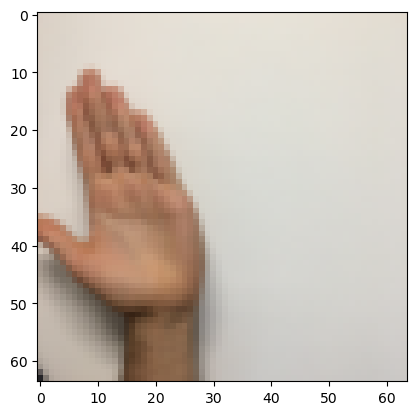

In [21]:
# Example of a picture
index = 300
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
print (classes)

From now implemnt your model. After that use transfer learning.
Please add cells and explain yours developing steps and your results.

استفاده از زبان فارسی برای توضیحات هم مجاز است

موفق باشید

In [ ]:
!pip install dataprep
!pip install pytorch_lightning

In [22]:
import pandas as pd
from dataprep.eda import create_report
from dataprep.eda import plot_missing
from dataprep.eda import plot_correlation
from dataprep.eda import plot
import torch 
from torch import nn 
import pytorch_lightning as pl 
import torch.nn.functional as F 
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader, Subset, Dataset
from torch.optim import SGD 
from pytorch_lightning import Trainer, loggers
from PIL import Image
#from torchsummary import summary

In [23]:
# normalization constants
MEAN = torch.tensor([0.5,0.5,0.5], dtype=torch.float32)
STD = torch.tensor([0.5,0.5,0.5], dtype=torch.float32)

In [36]:
a = pd.DataFrame(Y_train_orig.T)
a.head

<bound method NDFrame.head of       0
0     5
1     0
2     2
3     5
4     2
...  ..
1075  3
1076  1
1077  2
1078  4
1079  5

[1080 rows x 1 columns]>

In [26]:
print(X_train_orig[index].shape)
print(X_train_orig.shape)
print(Y_train_orig.shape)
print(X_test_orig.shape)
print(Y_test_orig.shape)

(64, 64, 3)
(1080, 64, 64, 3)
(1080,)
(120, 64, 64, 3)
(120,)


In [25]:
Y_train_orig = Y_train_orig.T
Y_test_orig = Y_test_orig.T
Y_train_orig = Y_train_orig.squeeze()
Y_test_orig = Y_test_orig.squeeze()

Training Dataset Consists of 1080 photos of 64x64x3 images in 5 classes

In [27]:
from fix import MyDataset

In [32]:
transform = transforms.Compose(
            [
                transforms.Resize(32),
                transforms.CenterCrop(32),
                transforms.ToTensor(),
                transforms.Normalize(MEAN.tolist(), STD.tolist()),
            ]
        )

In [33]:
Train_dataset = MyDataset(X_train_orig, Y_train_orig, transform=transform)
Test_dataset = MyDataset(X_test_orig, Y_test_orig, transform=transform)

In [144]:
class CNN(pl.LightningModule): 
    def __init__(self,trd,ted): 
        #super(model, self).__init__() 
        super().__init__()
        self.hparams['data_root'] = "data"
        self.hparams['log_dir'] = "logs"
        self.hparams['num_workers'] = 4
        self.hparams['image_size'] = 32
        self.hparams['max_epochs'] = 100
        self.hparams['batch_size'] = 100
        self.hparams['nc'] = 3
        self.hparams['nz'] = 512
        self.hparams['nfc'] = 16
        self.hparams['nfm'] = 6
        self.hparams['lr'] = 0.005
        self.hparams['gpus'] = 1
        self.criterion = nn.CrossEntropyLoss() 
        self.trd = trd
        self.ted = ted
        
        self.MLP = nn.Sequential(
            #nn.Linear(self.hparams.nz, 64),
            #nn.ReLU(),
            
            #nn.Dropout(0.3),
            #nn.Linear(64, 16),
            #nn.ReLU(),
            #nn.Dropout(0.3),
            
            #nn.Linear(64, self.hparams.nfm),
            nn.Linear(self.hparams.nz, self.hparams.nfm),
            nn.Sigmoid(),
            )
        
        self.CNN = nn.Sequential(
            nn.Conv2d(self.hparams.nc, self.hparams.nfc, 4, 2, 1, bias=False),#nc*32*32 --> 16*16*32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),#8*8*32
            nn.Conv2d(self.hparams.nfc, self.hparams.nfc * 2, 4, 2, 1, bias=False), #4*4*64
            nn.ReLU(),
            
            #nn.AvgPool2d(4, 4),#1*64
            
            #nn.MaxPool2d(2, 2),
            #nn.Conv2d(self.hparams.nfc*2, self.hparams.nfc * 4, 2, 1, 0, bias=False), #1*1*128
            #nn.ReLU(),
        )
        

    
    def forward(self, x): 
        batch_size, _, _, _ = x.size()
        x = self.CNN(x)
        x = x.view(-1,self.hparams.nz)
        x = self.MLP(x)
        return x 
    
    def configure_optimizers(self): 
        #return torch.optim.SGD(self.parameters(), lr=self.hparams.lr, momentum= 0.1) 
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    

    def training_step(self, train_batch, batch_idx): 
        x, y = train_batch 
        output = self.forward(x) 
        
        encoded_labels = torch.zeros(len(y),6)
        for i in range(len(y)):
          encoded_labels[i][(y[i])]=1
        encoded_labels = encoded_labels.to('mps')
        
        loss = self.criterion(output, encoded_labels) 
        
        logs = {"loss": loss}
        return {"loss": loss, "log": logs}
    
    def validation_step(self, valid_batch, batch_idx): 
        x, y = valid_batch 
        output = self.forward(x) 
        
        encoded_labels = torch.zeros(len(y),6)
        for i in range(len(y)):
          encoded_labels[i][(y[i])]=1
        encoded_labels = encoded_labels.to('mps')
        
        loss = self.criterion(output, encoded_labels)
        
        logs = {"val_loss": loss}
        return {"val_loss": loss, "log": logs}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        logs = {"avg_val_loss": avg_loss}
        return {"avg_val_loss": avg_loss, "log": logs}
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        output = self.forward(x)
        
        encoded_labels = torch.zeros(len(y),6)
        for i in range(len(y)):
          encoded_labels[i][(y[i])]=1
        encoded_labels = encoded_labels.to('mps')
        
        loss = self.criterion(output, encoded_labels)

        logs = {"test_loss": loss}
        return {"test_loss": loss, "log": logs}
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        logs = {"avg_test_loss": avg_loss}
        return {"avg_test_loss": avg_loss, "log": logs}
        
    def prepare_data(self):
        transform = transforms.Compose(
            [
                transforms.Resize(self.hparams.image_size),
                transforms.CenterCrop(self.hparams.image_size),
                transforms.ToTensor(),
                transforms.Normalize(MEAN.tolist(), STD.tolist()),
            ]
        )
        
        #Train_dataset = MyDataset(X_train_orig, Y_train_orig, transform=transform)
        #Test_dataset = MyDataset(X_test_orig, Y_test_orig, transform=transform)
        Train_dataset = self.trd
        Test_dataset = self.ted
 
        # train, val and test split
        end_train_idx = 850
        end_val_idx = len(Train_dataset)

        self.train_dataset = Subset(Train_dataset, range(0, end_train_idx))
        self.val_dataset = Subset(Train_dataset, range(end_train_idx + 1, end_val_idx))
        self.test_dataset = Test_dataset
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True, num_workers=self.hparams.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers
        )

In [ ]:
#test current config with nf=16
clf = CNN(Train_dataset,Test_dataset)
logger = loggers.TensorBoardLogger(clf.hparams.log_dir, name=f"bs{clf.hparams.batch_size}_nf{clf.hparams.nfc}", log_every_n_steps=10)

# print detailed summary with estimated network size
#summary(clf, (clf.hparams.nc, clf.hparams.image_size, clf.hparams.image_size), device="cpu")

trainer = Trainer(logger = logger, accelerator='mps', devices=clf.hparams.gpus, max_epochs=clf.hparams.max_epochs)
trainer.fit(clf)

In [146]:
torch.save(clf.state_dict(), 'outputs/CNN16SL.pth')

In [147]:
trainer.test(clf)

Testing: 0it [00:00, ?it/s]

[{}]

In [148]:
test_dataloader = DataLoader(clf.test_dataset,batch_size = 120)
test_features, test_labels = next(iter(test_dataloader))
a=clf(test_features)
predicted = torch.max(a, 1)[1]

In [149]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(test_labels,predicted))
print(classification_report(test_labels,predicted))

[[20  0  0  0  0  0]
 [ 0 19  1  0  0  0]
 [ 0  2 16  0  0  2]
 [ 0  0  0 20  0  0]
 [ 0  0  0  2 17  1]
 [ 0  0  0  0  0 20]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.90      0.95      0.93        20
           2       0.94      0.80      0.86        20
           3       0.91      1.00      0.95        20
           4       1.00      0.85      0.92        20
           5       0.87      1.00      0.93        20

    accuracy                           0.93       120
   macro avg       0.94      0.93      0.93       120
weighted avg       0.94      0.93      0.93       120



In [ ]:
#CNN with 4*4*64 output --> 93% Accurate and faster training
#CNN with 1*1*64 output after avgpool --> 88% Accurate and longer training
#4*4*64 CNN + MLP with sigmoid at the end, plateus as 1.05 loss --> 95% accuracy. all below use this MLP config
#CNN+ with 1*1*128 output after maxpool,conv2d,relu --> plateu at 30 epoch and 1.1 loss --> 77% accuracy! (f1 scores for one and two fingers are very low due to being lost in the last layer)
#CNN with 4*4*16 output --> plateu at 35 epoch at 1.11 loss --> 81% accuracy
#CNN16 with 4*4*32 output --> plateu at 40 epochs at 1.05 loss --> 94% accuracy
#CNN16 with 4*4*32 output passed to a single linear network + sigmoid --> plateu at 50 epochs at 1.06 loss --> 93% accuracy

#Lightest accurate model was CNN16 + single linear + sigmoid

In [ ]:
clf = CNN(Train_dataset,Test_dataset)
clf.load_state_dict(torch.load('outputs/CNN.pth', map_location=torch.device('mps')))
clf.eval()